# Notebook to compare BigSCale network inference to SCENIC

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

## Load SCENIC network

In [2]:
#Loading network
network = pd.read_csv('data/regulon_network_links.tsv', sep = '\t', index_col = 0)
network.columns = ['From', 'To', 'Weight']

network.From = [x.strip('(+)') for x in network.From] #remove extra characters after TF name
network.To = [x.strip('(+)') for x in network.To]
         

## Load BigSCale network

In [3]:
BS = pd.read_csv('BigScale2_tm10x_network.txt', sep = ' ')

In [4]:
BS.head()

,Prdm2,Otud1,Tmod3,Gm15441,Iqgap1,Clk3,Fbxo42,Cdc16,Mid1ip1,Map3k2,...,Glt8d1,Nucb2,Gmnn,Eif1ad,Ccng2,Zfyve27,Nr2c2ap,Myl7,Ccdc82,Cwc15
Prdm2,1.000000,-0.017016,0.502087,0.581621,0.272688,-0.117936,0.379839,0.271309,0.070676,0.734472,...,0.652853,0.570403,-0.473770,-0.430614,0.033435,0.236796,-0.245531,0.000125,0.474720,-0.146014
Otud1,-0.017016,1.000000,0.443534,0.010255,-0.298726,0.427149,0.315050,0.562163,-0.004034,-0.080062,...,0.247967,-0.357512,0.059384,0.452838,0.141907,-0.158779,0.472738,0.516817,0.056667,0.144032
Tmod3,0.502087,0.443534,1.000000,0.379815,0.178275,0.463651,0.131793,0.363493,0.035262,-0.023787,...,0.241131,0.209372,-0.073459,-0.036633,0.234611,0.063680,0.165226,0.269980,0.348587,-0.077594
Gm15441,0.581621,0.010255,0.379815,1.000000,0.502065,0.134367,0.273587,-0.046643,-0.249169,0.327850,...,0.207298,0.179805,0.148379,-0.066630,0.336368,0.504207,0.076230,-0.173634,0.701762,0.272079
Iqgap1,0.272688,-0.298726,0.178275,0.502065,1.000000,-0.019528,-0.009576,-0.399429,-0.385980,-0.092988,...,-0.111174,0.434899,0.094793,-0.183758,0.070385,0.293418,-0.030995,-0.180478,0.397585,0.181696


In [5]:
BS[BS < 0.9] = np.NaN #Mask links less than the correlation threshold
BS[BS == 1.] = np.NaN #Mask lisks to self

In [6]:
BS['genes'] = BS.index

In [7]:
BS = pd.melt(BS, id_vars=['genes'])
BS.columns = ['From', 'To', 'Correlation']

In [8]:
BS.head()

,From,To,Correlation
0,Prdm2,Prdm2,NaN
1,Otud1,Prdm2,NaN
2,Tmod3,Prdm2,NaN
3,Gm15441,Prdm2,NaN
4,Iqgap1,Prdm2,NaN


In [9]:
BS = BS.dropna() #Remove maksed links

In [10]:
BS.shape

(118768, 3)

## Compare predicted TF interactions

In [11]:
#Confirm that we ahve 174 links in our consensus regulon network
TFs = network.From.unique().tolist()
len(TFs)

174

In [12]:
sub_From = [x in TFs for x in BS.From] #Mask to subset by. Which in BigScale are also in SCENIC concensus network   

BS_sub = BS.loc[sub_From] #Subset based on TF's in SCENIC network

#How many TF from SCENIC network is also in BigSCale network
print(len(set(BS_sub.From)), """out of 174 TF's are also found in the BigSCale Network""")

#How many links is inferred between TF's using BigSCale
sub_To = [x in TFs for x in BS_sub.To]
BS_sub = BS_sub.loc[sub_To]

print("""BigSCale identify {} links between TF's""".format(BS_sub.shape[0] / 2))

117 out of 174 TF's are also found in the BigSCale Network
BigSCale identify 37.0 links between TF's


## Compare TF downstream genes (regulons)

### Load regulon composition (SCENIC)

In [14]:
DATA_FOLDER="/work/sduknn/Andreas/TM_MCA/database_SCENIC/tmp/droplet"
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons_10_percent.p")

#Reload regulons and motifs
with open(REGULONS_FNAME, "rb") as f:
    regulons_drop = pickle.load(f)

    
    

In [15]:
#Convert to Tabular form
def info_table(regulons):
    regulon_names = [x.name for x in regulons]
    #function that outputs a list of gene names present in a given regulon
    def find_reg_genes(regulon_name, regulons):
        x=0
        for i in regulons:
            if i.name != regulon_name:
                x = x + 1
            else:
                return [k  for  k in  regulons[x].gene2weight.keys()]

    genes = [find_reg_genes(x, regulons) for x in regulon_names]
    regulon_info = pd.DataFrame({'Regulon':[x.strip('(+)') for x in regulon_names],
                  'genes':genes,
                  'N_genes':[len(x) for x in genes] })
    #regulon_info.index = regulon_info['Regulon'].astype(str) + ' g'+regulon_info['N_genes'].astype(str)
    regulon_info.index = regulon_info['Regulon'].astype(str)
    return regulon_info

In [16]:
network_comp =info_table(regulons_drop)

### Get targets (BigSCale)

In [17]:

def get_BS_genes(tf):
    return BS[BS['From'] == tf].To.tolist()
    

In [18]:
get_BS_genes('Junb')

['Jund', 'Socs3', 'Tuba1a', 'Nfkbiz', 'Pmp22', 'Adamts1', 'Btg2', 'Prickle2']

## Composition similarities (Jaccard index)

In [19]:
def intersection(s1, s2) : 
  
    # Find the intersection of the two sets  
    intersect = s1 & s2 ; 
  
    return intersect;  

# Function to return the Jaccard index of two sets  
def jaccard_index(s1, s2) : 
      
    # Sizes of both the sets  
    size_s1 = len(s1);  
    size_s2 = len(s2);  
  
    # Get the intersection set  
    intersect = intersection(s1, s2);  
  
    # Size of the intersection set  
    size_in = len(intersect);  
  
    # Calculate the Jaccard index  
    # using the formula  
    jaccard_in = size_in  / (size_s1 + size_s2 - size_in);  
  
    # Return the Jaccard index  
    return jaccard_in




### Compute method specific and common genes and jaccard index

In [20]:

di_int = {}
di_jc = {}
di_BS = {}
di_SCENIC = {}
for i in network_comp.index:
    if len(get_BS_genes(i)) > 0:
        di_int[i] =len(intersection(set(get_BS_genes(i)), set(network_comp.loc[i].genes)))
        
        di_BS[i] =len(get_BS_genes(i)) - di_int[i]
        di_SCENIC[i] =len(network_comp.loc[i].genes) - di_int[i]
        
        di_jc[i] =jaccard_index(set(get_BS_genes(i)), set(network_comp.loc[i].genes))

In [21]:
#Format Jaccard index output
jaccard = pd.DataFrame(di_jc, index = ['Jaccard']).T.sort_values('Jaccard', ascending = False)

In [22]:
#Format gene overlap
intersect = pd.DataFrame(di_int, index = ['Intersection']).T.sort_values('Intersection', ascending = False)
BS_specific = pd.DataFrame(di_BS, index = ['BigSCale']).T
SCENIC_specific = pd.DataFrame(di_SCENIC, index = ['SCENIC']).T

merge = pd.concat([BS_specific, intersect, SCENIC_specific], axis = 1)

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


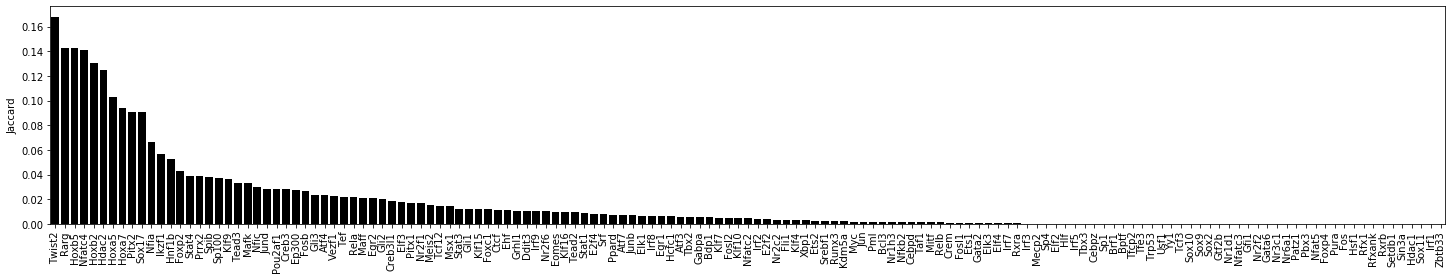

In [38]:
# Plot Jaccard index
plt.figure(figsize = (25,4))
ax = sns.barplot(x = jaccard.index, y=jaccard.Jaccard, color = 'k', rasterized = True)
plt.xticks(rotation=90)
plt.savefig('figures/BS_SCENIC_jaccard.pdf', dpi = 500)

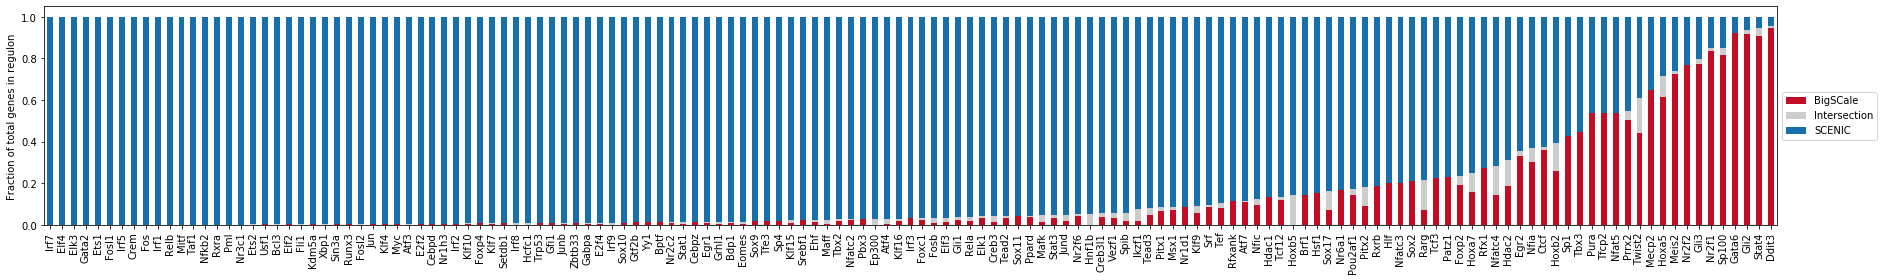

In [36]:
#Plot regulon overlap

temp = merge.divide(merge.sum(axis = 1), axis = 0)
order = temp.sort_values(['SCENIC', 'BigSCale'], ascending=[False, True]).index #order TF's
temp = temp.loc[order]


ax = temp.plot(kind = 'bar', stacked = True, figsize = (35,4),
                                                     color = ["#c30d24", "#cccccc", "#1770ab"], 
                                                     rasterized = True)
# Shrink current axis by 30%
plt.tight_layout()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Fraction of total genes in regulon')
plt.savefig('figures/BS_SCENIC_stacked_fraction.pdf', dpi = 500)

In [45]:
temp.index.to_series().to_csv('fraction_order.txt', index = False)

In [44]:
jaccard.index.to_series().to_csv('jaccard_order.txt', index = False)